# Previsão de séries temporais com sktime
### Equipe de Apoio: Moisés Santos. Contatos: [LinkedIn](https://www.linkedin.com/in/moises-rocha-santos/), [Github](https://github.com/moisesrsantos)

Hoje vamos ver alguns tópicos de introdução à previsão de séries temporais com o pacote sktime.
Primeiramente, vamos carregar as bibliotecas necessárias para a prática.

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.arima import AutoARIMA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.model_selection import SlidingWindowSplitter, temporal_train_test_split
from sktime.transformations.series.impute import Imputer
import numpy as np
import matplotlib.dates as mdates

rcParams['figure.figsize'] = 18, 8

Primeiro, vamos carregar os dados que utilizaremos nesta prática. É um conjunto de dados referentes à carga de energia elétrica no armazenamento do Sistema Interligado Nacional (SIN). O SIN é responsável pela produção e transmissão de energia elétrica do Brasil. Os dados para análise estão disponíveis no [Link](http://www.ons.org.br/Paginas/resultados-da-operacao/historico-da-operacao/carga_energia.aspx).

In [33]:
data = pd.read_csv("ts_energy_data.csv", index_col=0)

Vamos fazer uma análise para saber como está organizado nosso conjunto de dados.

In [34]:
data.head()

,Carga SIN
Mês,
Jan-99,29662.387500
Feb-99,39944.777500
Mar-99,40578.397500
Apr-99,40877.012500
May-99,34036.776667


In [35]:
data.tail()

,Carga SIN
Mês,
Feb-20,68017.089750
Mar-20,57329.010417
Apr-20,62386.588500
May-20,53401.705416
Jun-20,56573.485042


A nossa coluna mês não está no formato datetime, então vamos criar o mesmo intervalo de tempo no formato datetime.

In [36]:
pd.date_range(start = '01/31/1999', end = '06/30/2020', freq='M')

DatetimeIndex(['1999-01-31', '1999-02-28', '1999-03-31', '1999-04-30',
               '1999-05-31', '1999-06-30', '1999-07-31', '1999-08-31',
               '1999-09-30', '1999-10-31',
               ...
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30'],
              dtype='datetime64[ns]', length=258, freq='M')

Agora iremos transformar para um tipo de dado compatível com o pacote sktime (Series pandas).

In [38]:
data_SIN = pd.Series(data["Carga SIN"].values, index=pd.date_range(start = '01/31/1999', end = '06/30/2020', freq='M'))

In [39]:
data_SIN

1999-01-31    29662.387500
1999-02-28    39944.777500
1999-03-31    40578.397500
1999-04-30    40877.012500
1999-05-31    34036.776667
                  ...     
2020-02-29    68017.089750
2020-03-31    57329.010417
2020-04-30    62386.588500
2020-05-31    53401.705416
2020-06-30    56573.485042
Freq: M, Length: 258, dtype: float64

Vamos agora visualizar a série temporal

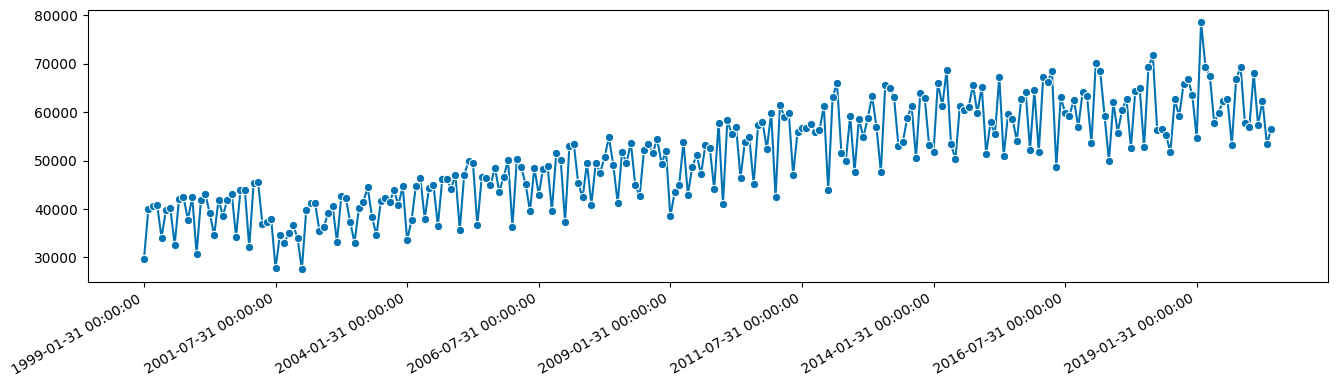

In [41]:
fig, ax = plot_series(data_SIN)
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.show()

Agora vamos ver a decomposição STL de que falamos na prática.

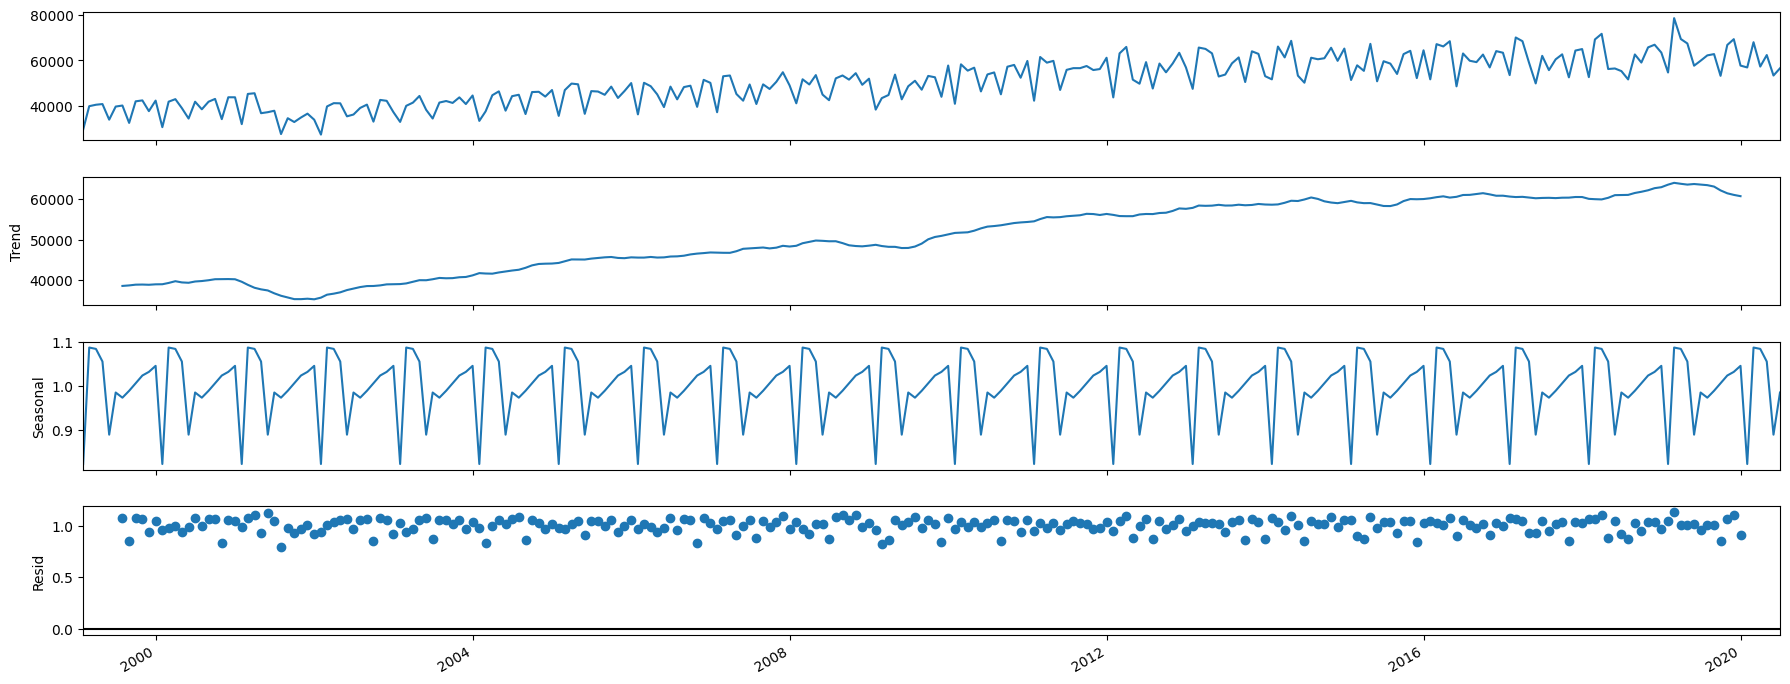

In [42]:
fig = seasonal_decompose(data_SIN,model="multiplicative",period=12).plot()
fig.autofmt_xdate()
plt.show()

Agora vamos ao aprendizado de máquina de fato. Primeiro vamos particionar os dados. Importante: em séries temporais a ordem é importante, então não podemos fazer splits que peguem os dados aleatoriamente. No sktime tenho funções específicas para fazer este split.

In [43]:
y_train, y_test = temporal_train_test_split(pd.Series(data_SIN.values), test_size=0.25)

Agora vamos visualizar para saber como ficou nosso split.

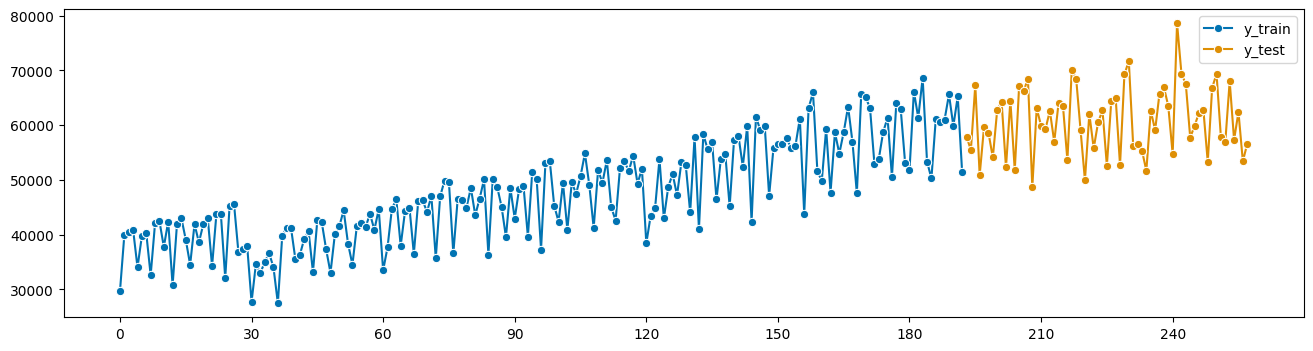

193 65


In [44]:
plot_series(y_train, y_test, labels=["y_train", "y_test"])
plt.show()
print(y_train.shape[0], y_test.shape[0])

## Modelo de previsão naive

Antes de vermos coisas mais sofisticadas, vamos começar pelo simples.

O modelo naive (ingênuo), é a previsão com se no período sazonal anterior.

Exemplo: se tenho uma série temporal semanal da previsão do tempo dizendo que fez uma média de 25 graus no sábado passado, meu modelo de previsão naive irá dizer que vai fazer 25 graus hoje.

In [46]:
fh_1 = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = NaiveForecaster(strategy="last", sp=12)

forecaster.fit(y_train)

y_pred = forecaster.predict(fh_1)
naive = y_pred

Agora vamos fazer o plot para ver como foi a nossa previsão.

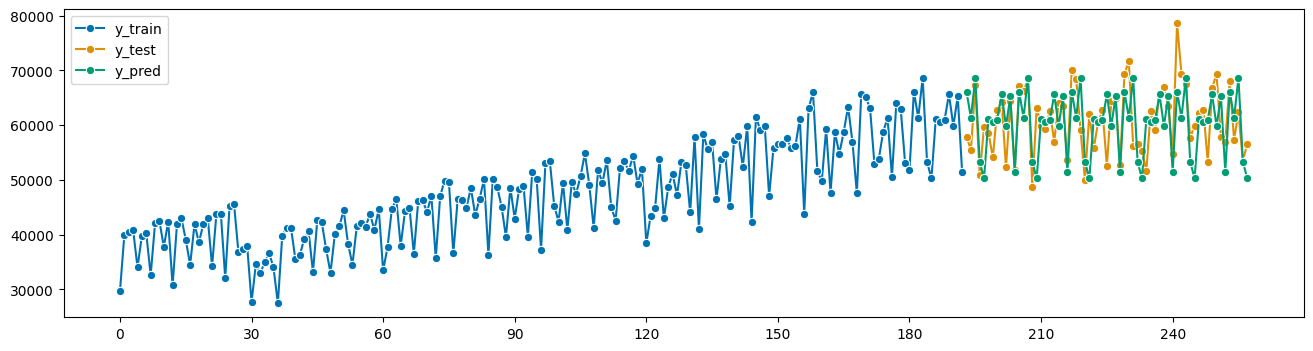

In [47]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.show()

Uma métrica que já conhecemos, o MAPE, assim como outras métricas de regressão podem ser usadas para medir o desempenho da previsão de séries temporais.

In [48]:
mean_absolute_percentage_error(y_test, y_pred)*100

7.797720172837005

## Métricas

Algumas métricas vocês já conhecem que são herdadas da tarefa de regressão, como MSE, MAE, MAPE, etc. Outras são específicas de previsão de séries temporais e podem ser interessantes no que vocês irão aplicar no futuro.

**Theils U (TU)**: Esta métrica mede o quão bom é o seu modelo de previsão em relação ao modelo naive. 

**Prediction Of Change In Direction (POCID)**: Esta métrica mede o quanto o seu modelo consegue prever a direção da tendência de seus dados.

Como não temos a implementação delas, vamos implementá-las em Python.

In [50]:
def TU(y_test, y_pred, naive):
    return sum(np.power((y_test - y_pred), 2))/sum(np.power((y_test - naive), 2))
    
def POCID(y_test, y_pred):
    diff_original= (y_test-y_test.shift(1)).dropna().values
    diff_pred= (y_pred-y_pred.shift(1)).dropna().values
    is_positive = (diff_original * diff_pred)>0
    return (is_positive.sum()/len(is_positive)) * 100


Podemos ver o desempenho do naive para esta tarefa com nossas novas métricas e interpretar o que querem dizer.

In [51]:
print(TU(y_test, y_pred, naive))
print(POCID(y_test, y_pred))

1.0
56.25


## ARIMA no sktime

Assim como uma infraestrutura para trabalhar com aprendizado de máquina, no pacote sktime também temos técnicas estatísticas como ARIMA, ETS, Theta, entre outras.
Vamos avaliar o desempenho do AutoARIMA para a tarefa de previsão.

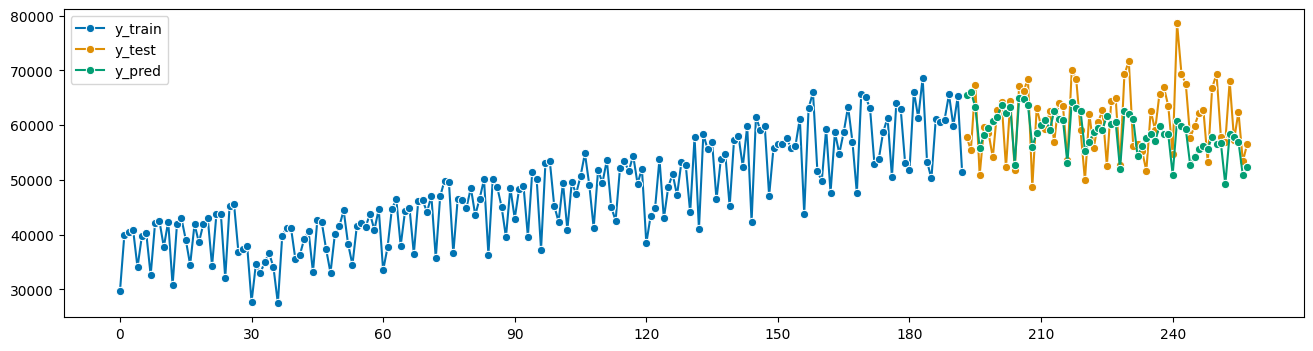

7.982595178535163
0.9778377485107514
65.625


In [52]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh_1)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.show()
print(mean_absolute_percentage_error(y_test, y_pred)*100)
print(TU(y_test, y_pred, naive))
print(POCID(y_test, y_pred))

In [53]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  193
Model:             SARIMAX(2, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood               -1899.833
Date:                                 Sat, 28 Aug 2021   AIC                           3815.666
Time:                                         10:52:07   BIC                           3841.726
Sample:                                              0   HQIC                          3826.220
                                                 - 193                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -157.9306    171.551     -0.921      0.357    -494.164     178.302
ar.L1         -0.7579      0.079     -9.635      0.000      -0.912      -0.604
ar.L2         -0.5228      0.042    -12.407      0.000      -0.605      -0.440
ar.S.L12       0.2798      0.363      0.771      0.441      -0.431       0.991
ar.S.L24       0.6199      0.300      2.063      0.039       0.031       1.209
ma.S.L12       0.1077      0.376      0.287      0.774      -0.629       0.844
ma.S.L24      -0.5744      0.163     -3.516      0.000      -0.895      -0.254
sigma2       2.67e+07      0.004   7.18e+09      0.000    2.67e+07    2.67e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                29.80
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             0.35
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.2e+25. Standard errors may be unstable.
"""

## Aprendizado de máquina
Começando pelo KNN e vamos ver também a redução. Notem que estamos utilizando o KNN da biblioteca sklearn.

In [55]:
regressor = KNeighborsRegressor(n_neighbors=3)
forecaster = make_reduction(regressor, window_length=12, strategy="recursive")

Visto o que é redução, vamos ver o qual o desempenho do nosso KNN sem nenhum pré-processamento específico.

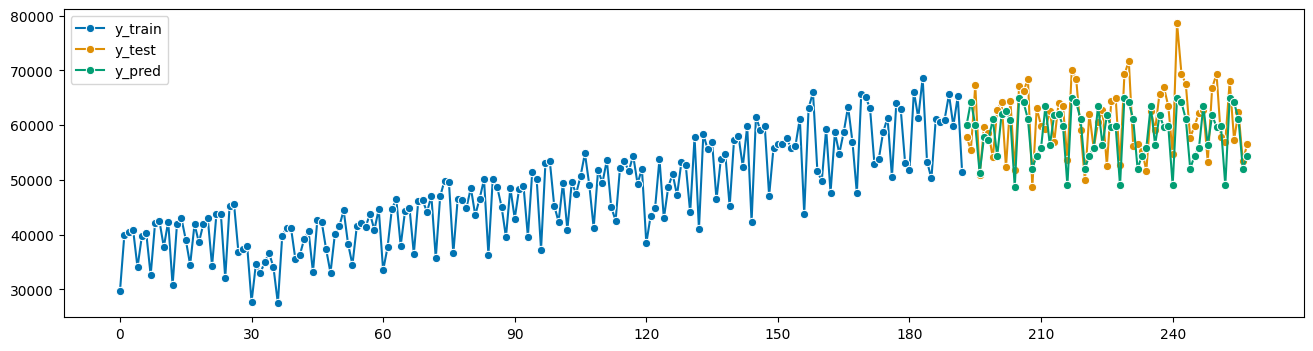

7.667967618847135
0.8072992044068001
62.5


In [58]:
forecaster.fit(y_train)
y_pred = forecaster.predict(fh_1)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.show()
print(mean_absolute_percentage_error(y_test, y_pred)*100)
print(TU(y_test, y_pred, naive))
print(POCID(y_test, y_pred))

E se quisermos recuperar os parâmetros do KNN?

In [57]:
forecaster.get_params()

{'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 3,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'estimator': KNeighborsRegressor(n_neighbors=3),
 'window_length': 12}

## Pipeline
Agora vamos ver um pipeline simples para a tarefa de previsão com as boas práticas:
- Imputação de dados
- Separar a sazonalidade
- Separar a tendência
- Fazer a previsão por redução

In [59]:
def get_transformed_target_forecaster(regressor):    
    forecaster = TransformedTargetForecaster( steps=
        [
            ("imputer", Imputer(method="linear")),
            ("deseasonalise", Deseasonalizer(model="multiplicative", sp=12)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
            ("forecast", make_reduction(regressor, window_length=12, strategy="recursive")),
        ]
    )
    return forecaster

Feito isso agora iremos avaliar o desempenho da previsão com o pré-processamento.

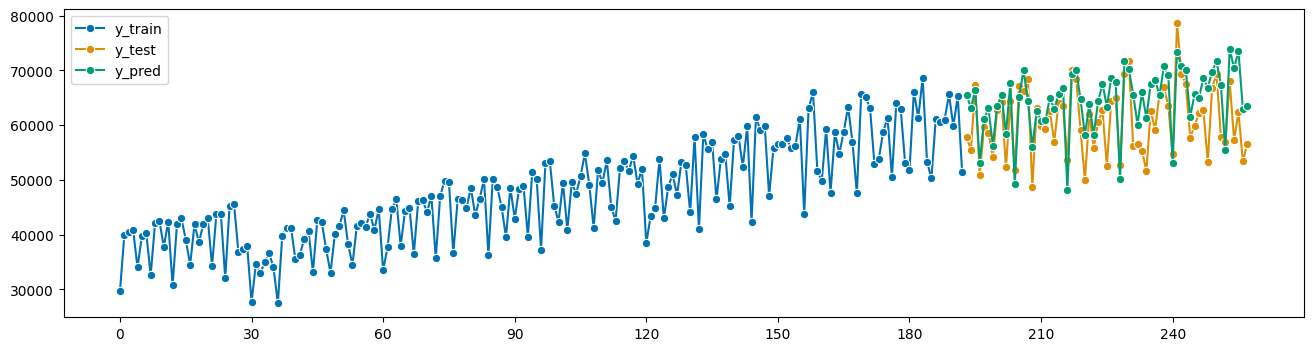

7.390739952645034
0.8839067109959177
79.6875


In [60]:
forecaster = get_transformed_target_forecaster(KNeighborsRegressor())
forecaster.fit(y_train)
y_pred = forecaster.predict(fh_1)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.show()
print(mean_absolute_percentage_error(y_test, y_pred)*100)
print(TU(y_test, y_pred, naive))
print(POCID(y_test, y_pred))

Agora vamos ver para o algoritmo de regressão linear

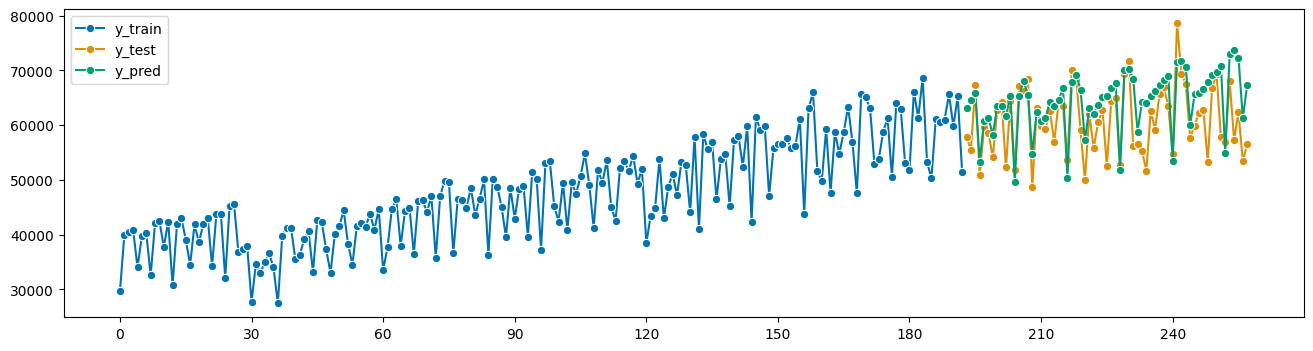

7.2248285267602075
0.9949369704891743
73.4375


In [61]:
forecaster = get_transformed_target_forecaster(LinearRegression())
forecaster.fit(y_train)
y_pred = forecaster.predict(fh_1)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.show()
print(mean_absolute_percentage_error(y_test, y_pred)*100)
print(TU(y_test, y_pred, naive))
print(POCID(y_test, y_pred))

Agora vamos ver o algoritmo Random Forest, que vocês viram na disciplina ICD.

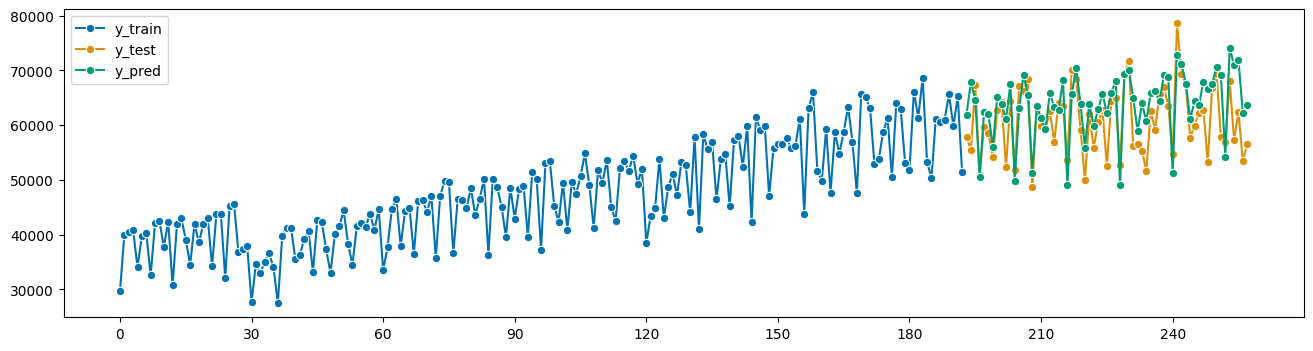

6.885291068659464
0.8096254586890039
79.6875


In [62]:
forecaster = get_transformed_target_forecaster(RandomForestRegressor(random_state=14))
forecaster.fit(y_train)
y_pred = forecaster.predict(fh_1)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.show()
print(mean_absolute_percentage_error(y_test, y_pred)*100)
print(TU(y_test, y_pred, naive))
print(POCID(y_test, y_pred))

## E com NAs?

Agora vamos ver como nossos algoritmos se comportam com dados faltantes. O mesmo conjunto de dados foi criado mas retirando aleatoriamente alguns dados.

In [63]:
data_SIN_na = pd.read_csv("ts_energy_data_na.csv", index_col=0)
data_SIN_na = pd.Series(data_SIN_na["Carga SIN"].values, index=pd.date_range(start = '01/31/1999', end = '06/30/2020', freq='M'))

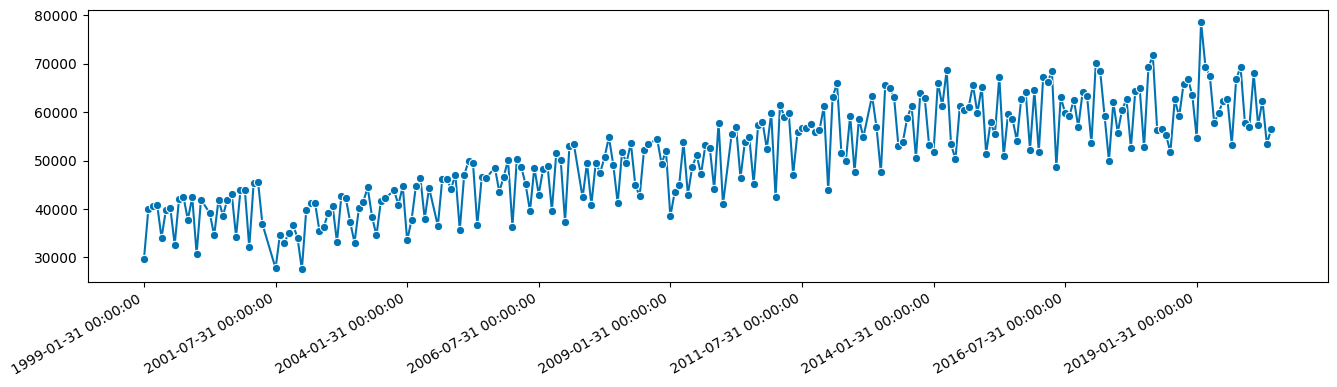

In [64]:
fig, ax =plot_series(data_SIN_na)
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.show()

In [65]:
np.isnan(data_SIN_na.values).sum()

10

In [66]:
y_train_na, y_test_na = temporal_train_test_split(pd.Series(data_SIN_na.values), test_size=0.25)

In [67]:
forecaster = NaiveForecaster(strategy="last", sp=12)

forecaster.fit(y_train_na)

y_pred_na = forecaster.predict(fh_1)
naive_na = y_pred_na

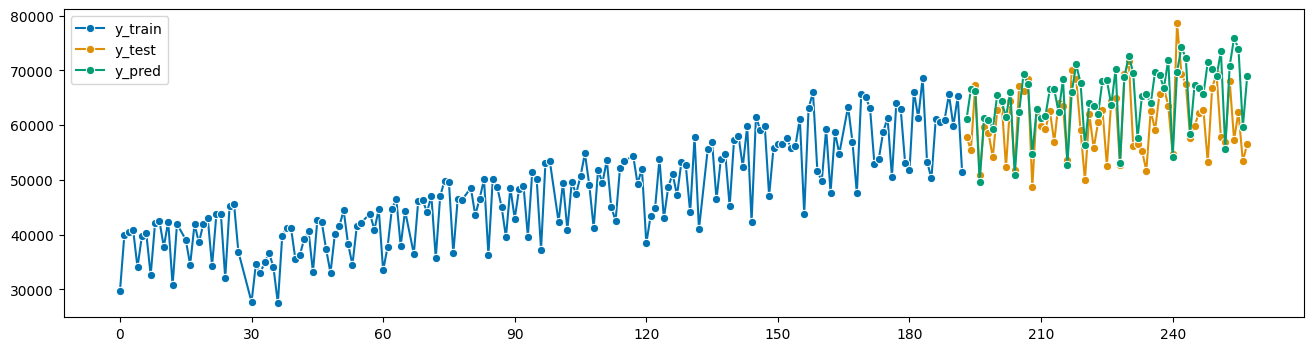

8.053507316623202
1.3613343390220545
54.6875


In [68]:
forecaster = get_transformed_target_forecaster(RandomForestRegressor(random_state=14))
forecaster.fit(y_train_na)
y_pred = forecaster.predict(fh_1)
plot_series(y_train_na, y_test_na, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.show()

print(mean_absolute_percentage_error(y_test, y_pred)*100)
print(TU(y_test_na, y_pred, naive_na))
print(POCID(y_test_na, y_pred))